In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV,LeaveOneOut

import ksource_py as ks

In [2]:
# Abrir lista de particulas

folder = "Ftes_tracks"
tracks = folder+"/GF12p_n"
trasl = [118.5497276, -102.897199, 5.0]
rot = [0.0, 0.0, -158*np.pi/180.0]
x2z = True

set_params = False
plist = ks.PList(ks.PTRAC_read, tracks, trasl=trasl, rot=rot, switch_x2z=x2z, set_params=set_params)
if set_params:
    print("N =", plist.N)
    print("I =", plist.I)
    print("err =", np.sqrt(plist.p2))

In [3]:
# Crear KSource

J = 3.669E+15
metric = ks.SepVarMetric(ks.Lethargy(10), ks.SurfXY(0), ks.Polar())
s = ks.KSource(metric, bw="silv", J=J)

### Optimizacion de BW

In [4]:
# Metodo de Silverman

s.bw_method = "silv"
N = 1E4
s.fit(plist, N, N_tot=2991283)
s.save_bw(tracks+"_bw_silv.txt")

[ 1.38846564 12.49661901 12.59388088  0.22596037  1.82292471]
Calculating bw ... [ 1.38846564 12.49661901 12.59388088  0.22596037  1.82292471]
Done
Optimal bw (silv) = [0.24887693 2.23996913 2.25740294 0.0405025  0.32675199]


[ 1.38846564 12.49661901 12.59388088  0.22596037  1.82292471]
Calculating bw ... [ 1.38846564 12.49661901 12.59388088  0.22596037  1.82292471]
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    3.1s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    4.8s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.9s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    7.1s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    8.5s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:   10.5s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:   12.6s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:   14.9s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   17.0s
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed:   19.8s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:   22.5s
[Parallel(n_jobs=8)]: Done 165 tasks      | elapsed:   25.9s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   29.9s
[Parallel(

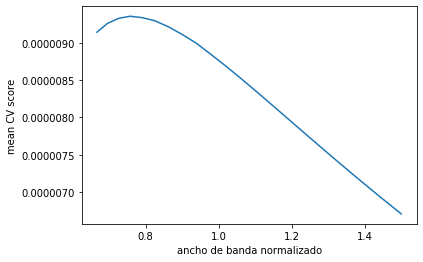

Done
Optimal bw (mlcv) = [0.1885824  1.69729973 1.7105099  0.0306901  0.24759094]


In [5]:
# Metodo de Max Likelihood Cross Validation

s.bw_method = "mlcv"
N = 1E4
s.fit(plist, N, N_tot=2991283)
s.save_bw(tracks+"_bw_mlcv.txt")

In [5]:
# Metodo de K Nearest Neighbours

s.bw_method = "knn"
N = 10000
s.fit(plist, N, N_tot=100000)#2991283)
s.save_bw(tracks+"_bw_knn.txt")
print(s.bw.mean(axis=0))

Calculando bw ... 
batch = 1 / 1
Hecho
Optimal bw (knn) = [[0.24665426 2.2199644  2.23724251 0.04014078 0.32383383]
 [0.14525827 1.3073692  1.31754452 0.02363948 0.19071043]
 [0.31091005 2.79828637 2.82006559 0.05059783 0.40819564]
 ...
 [0.29764812 2.67892489 2.69977511 0.04843957 0.39078397]
 [0.38818351 3.49377136 3.52096357 0.0631734  0.50964842]
 [0.24748212 2.22741537 2.24475146 0.0402755  0.32492073]]
[0.30241347 2.72181453 2.74299856 0.04921509 0.39704043]
